# Convolutional Neural Network State Discrimination Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.13.1 matplotlib==3.9.2 seaborn==0.13.2 qutip==5.0.4 scikit-learn==1.5.1 tensorflow==2.10.0
!pip install -i https://test.pypi.org/simple/ qsttoolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled k

Looking in indexes: https://test.pypi.org/simple/


## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We first create batches of optical quantum state vectors of seven different varieties. `qsttoolkit.data` provides classes to produce such batches, each state with randomised parameters within given limits, based on the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework:

In [3]:
dim = 32

fock_batch = qst.data.FockStates(n_states = 1000,
                                 N = dim,
                                 n_range = [0, dim])
coherent_batch = qst.data.CoherentStates(n_states = 1000,
                                         N = dim,
                                         alpha_magnitude_range = [1e-6, 3])
thermal_batch = qst.data.ThermalStates(n_states = 1000,
                                       N = dim,
                                       nbar_range = [0, dim])
num_batch = qst.data.NumStates(n_states = 1000,
                               N = dim,
                               types = ['17', 'M', 'P', 'P2', 'M2'])
binomial_batch = qst.data.BinomialStates(n_states = 1000,
                                         N = dim,
                                         S_range = [1, 10],
                                         mu_range = [0, 2])
cat_batch = qst.data.CatStates(n_states = 1000,
                               N = dim,
                               alpha_magnitude_range = [0, 10])
random_batch = qst.data.RandomStates(n_states = 1000,
                                     N = dim)
print('States generated')

/usr/local/lib/python3.10/dist-packages/qsttoolkit/data/state_batches.py:149: UserWarning: thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


States generated


/usr/local/lib/python3.10/dist-packages/qsttoolkit/data/state_batches.py:333: UserWarning: Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Parameters for noise sources that are applied to the density matrix and Husimi-Q representation:

In [4]:
mixed_state_noise_noise_level = 0.3   # Mixed state noise coefficient
affine_theta = 30                     # Maximum affine transformation theta
affine_x = 0.1                        # Maximum affine transformation x shift
affine_y = 0.1                        # Maximum affine transformation y shift
additive_Gaussian_stddev = 0.01       # Additive Gaussian noise distribution standard deviation
salt_and_pepper_prob = 0.1            # Salt and pepper noise pixel cutout probability

We initialise the Husimi-Q phase space before creating measurement data:

In [5]:
latent_dim = 32
xgrid = np.linspace(-5, 5, latent_dim)
pgrid = np.linspace(-5, 5, latent_dim)

We then create density matrices and Husimi-Q measurement images, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()` and measurement noise using `qsttoolkit.data.apply_measurement_noise()`:

In [6]:
fock_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
coherent_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
thermal_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
num_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
binomial_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
cat_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
random_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
print("DataFrames initialised")

fock_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in fock_batch.density_matrices()]
fock_data['label'] = ['fock']*len(fock_densities)
fock_data['density_matrix'] = [dm.full() for dm in fock_densities]
fock_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in fock_densities]
fock_data['state_parameter'] = fock_batch.params
print("Fock data generated")

coherent_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in coherent_batch.density_matrices()]
coherent_data['label'] = ['coherent']*len(coherent_densities)
coherent_data['density_matrix'] = [dm.full() for dm in coherent_densities]
coherent_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in coherent_densities]
coherent_data['state_parameter'] = coherent_batch.params
print("Coherent data generated")

thermal_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in thermal_batch.density_matrices()]
thermal_data['label'] = ['thermal']*len(thermal_densities)
thermal_data['density_matrix'] = [dm.full() for dm in thermal_densities]
thermal_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in thermal_densities]
thermal_data['state_parameter'] = thermal_batch.params
print("Thermal data generated")

num_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in num_batch.density_matrices()]
num_data['label'] = ['num']*len(num_densities)
num_data['density_matrix'] = [dm.full() for dm in num_densities]
num_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in num_densities]
num_data['state_parameter'] = num_batch.params
print("Num data generated")

binomial_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in binomial_batch.density_matrices()]
binomial_data['label'] = ['binomial']*len(binomial_densities)
binomial_data['density_matrix'] = [dm.full() for dm in binomial_densities]
binomial_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in binomial_densities]
binomial_data['state_parameter'] = binomial_batch.params
print("Binomial data generated")

cat_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in cat_batch.density_matrices()]
cat_data['label'] = ['cat']*len(cat_densities)
cat_data['density_matrix'] = [dm.full() for dm in cat_densities]
cat_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in cat_densities]
cat_data['state_parameter'] = cat_batch.params
print("Cat data generated")

random_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in random_batch.density_matrices()]
random_data['label'] = ['random']*len(random_densities)
random_data['density_matrix'] = [dm.full() for dm in random_densities]
random_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in random_densities]
random_data['state_parameter'] = random_batch.params
print("Random data generated")

data = pd.concat([fock_data, coherent_data, thermal_data, num_data, binomial_data, cat_data, random_data])
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset generated")

DataFrames initialised
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


Alternatively, QSTToolkit provides the `optical_state_dataset()` function which produces the above dataset in one function, which is intended to be used as a stamdardised dataset for training models:

In [7]:
data = qst.data.optical_state_dataset(dim=32, latent_dim=32)

/usr/local/lib/python3.10/dist-packages/qsttoolkit/data/state_batches.py:149: UserWarning: thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
/usr/local/lib/python3.10/dist-packages/qsttoolkit/data/state_batches.py:333: UserWarning: Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change

States generated
DataFrames initialised
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


## Modelling

Data preprocessing:

In [8]:
X = data['Husimi-Q_function']
y_raw = data['label']
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_raw)
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42)
latent_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, latent_dim, latent_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, latent_dim, latent_dim, 1)

We create an instance of the `qsttoolkit.tomography.CNNQuantumStateDiscrimination` class, which handles the model architecture, compiling and training:

In [9]:
state_discriminator = qst.tomography.CNNQuantumStateDiscrimination(dim=32,
                                                                   X_train=X_train,
                                                                   X_test=X_test,
                                                                   y_train=y_train,
                                                                   y_test=y_test,
                                                                   label_encoder=label_encoder,
                                                                   early_stopping_patience=3,
                                                                   lr_scheduler_factor=0.5,
                                                                   lr_scheduler_patience=2)

Model compiling and training using the `.train` method:

In [10]:
state_discriminator.train(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'],
                          epochs=20,
                          batch_size=32,
                          validation_split=0.2)

Epoch 1/20
140/140 [==============================] - 3s 15ms/step - loss: 1.4828 - accuracy: 0.4268 - val_loss: 0.9235 - val_accuracy: 0.6911 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 2s 14ms/step - loss: 0.7765 - accuracy: 0.7295 - val_loss: 0.5879 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 2s 15ms/step - loss: 0.6028 - accuracy: 0.7946 - val_loss: 0.4842 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 2s 14ms/step - loss: 0.5000 - accuracy: 0.8217 - val_loss: 0.5108 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 2s 16ms/step - loss: 0.4400 - accuracy: 0.8433 - val_loss: 0.3277 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 2s 14ms/step - loss: 0.3738 - accuracy: 0.8710 - val_loss: 0.2991 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 7/20
140/140 [==============================] - 2s 15ms/st

## Analysis and Evaluation

Inspection of accuracy and loss over training epochs:

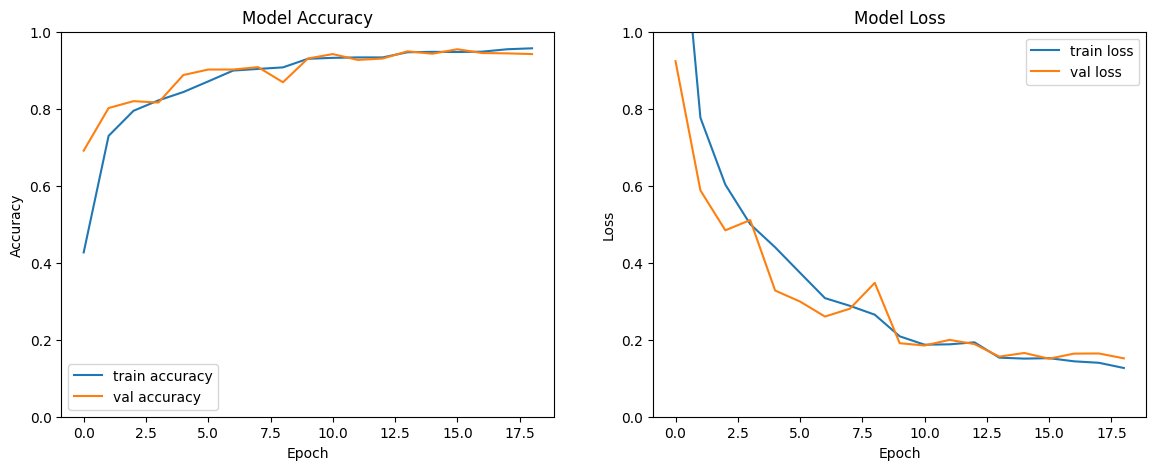

In [11]:
state_discriminator.plot_training()

Model evaluation:

44/44 [==============================] - 0s 4ms/step


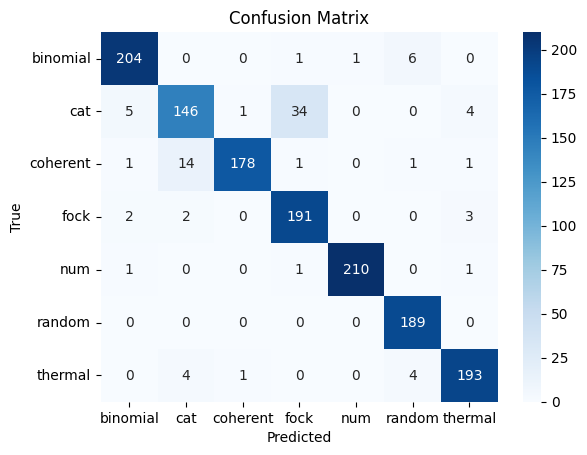

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       212
           1       0.88      0.77      0.82       190
           2       0.99      0.91      0.95       196
           3       0.84      0.96      0.90       198
           4       1.00      0.99      0.99       213
           5       0.94      1.00      0.97       189
           6       0.96      0.96      0.96       202

    accuracy                           0.94      1400
   macro avg       0.94      0.93      0.93      1400
weighted avg       0.94      0.94      0.94      1400



In [12]:
state_discriminator.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

Built-in `.classify` method to classify given input measurements and invert the label encoding, returning simply an array of label strings:

In [13]:
print(state_discriminator.classify(X_test))

44/44 [==============================] - 0s 4ms/step
['fock' 'binomial' 'thermal' ... 'num' 'random' 'coherent']


`CNNQuantumStateDiscrimination.model` can be treated as a `tensorflow.keras.Model` object, for example:

In [14]:
state_discriminator.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856 